# Import 

In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np 
from keras import layers
import keras
import os 
import glob
import random
import string
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data Pre-Processing

In [5]:
path1 = '/Data/train1/'
path2 = '/Data/train2/'

list_eyes = os.listdir(path1)
list_mouth = os.listdir(path2)

In [3]:
#Generating Random String
def random_string(panjang_string):
    return ''.join(random.choices(string.ascii_letters, 
                                        k=panjang_string))

def ganti_nama_random(path, list_dir, n):
    for i in list_dir:
        for j in os.listdir(path + i + '/'):
            name = path + i + '/' + random_string(n) + '.jpg'
            if not os.path.exists(name):
                rename = os.rename(path + i + '/' + j, 
                                   name)

#Membuat DataFrame
def dataframe_maker(data, columns):
    return pd.DataFrame(data, 
                        columns = columns)

#Mengumpulkan Data
def labelling(directory):
    label = []
    gambar = []
    for i in os.listdir(directory):
        for j in os.listdir(directory + i + '/'):
            if i == 'Closed' or i == 'yawn':
                label.append(1)
            else:
                label.append(0)

            read = tf.io.read_file(directory + i + '/' + j)
            gambar.append((tf.image.decode_image(read, channels = 3)).numpy())
    
    result = list(zip(gambar, label))
    random.shuffle(result)

    return result

def luminos_method(data):
    return 0.21*data[:, : , 0] + 0.72*data[:, : , 1] + 0.07*data[:, : ,2]

In [6]:
#Inisialisasi Data Gambar Mata
eyes = labelling(path1)
eyes_data, eyes_label = zip(*eyes)
eyes_data , eyes_label = list(eyes_data), list(eyes_label)

mouth = labelling(path2)
mouth_data, mouth_label = zip(*mouth)
mouth_data, mouth_label = list(mouth_data), list(mouth_label)

In [7]:
#Normalisasi Gambar
norm_img_eyes = []
norm_img_mouth = []

for i in range(len(eyes_data)):
    norm_eyes = luminos_method(eyes_data[i]).round()
    norm_img_eyes.append(norm_eyes)

    norm_mouth = luminos_method(mouth_data[i]).round()
    norm_img_mouth.append(norm_mouth)

In [8]:
img_size = 225
img_resized_eyes = []
img_resized_mouth = []

for i in range(len(eyes_data)):
    resized_eyes = cv2.resize(norm_img_eyes[i], (img_size, img_size)).round()
    img_resized_eyes.append(resized_eyes)

    resized_mouth = cv2.resize(norm_img_mouth[i], (img_size, img_size)).round()
    img_resized_mouth.append(resized_mouth)

# Transformasi Data

In [9]:
#Data Splitting untuk data mata
x_eyes, y_eyes = np.array(img_resized_eyes), np.array(eyes_label)
x_mouth, y_mouth = np.array(img_resized_mouth), np.array(mouth_label)

seed = 42
test_size = 0.2

eyes_train, eyes_test, eyes_lab_train, eyes_lab_test = train_test_split(x_eyes, y_eyes, random_state=seed, test_size=test_size)

mouth_train, mouth_test, mouth_lab_train, mouth_lab_test = train_test_split(x_mouth, y_mouth, random_state=seed, test_size=test_size)

# Membuat Arsitektur Model

In [10]:
input_eyes = tf.keras.Input(shape = (225,225,1), name= 'eyes_input')
input_mouth = tf.keras.Input(shape = (225,225,1), name = 'mouth_input')

x1 = tf.keras.layers.Rescaling(scale = 1./255.)(input_eyes)
x1 = tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation = 'relu', 
                            kernel_regularizer=tf.keras.regularizers.l2(0.001))(x1)
x1 = tf.keras.layers.MaxPool2D()(x1)
x1 = tf.keras.layers.Flatten()(x1)

x2 = tf.keras.layers.Rescaling(scale = 1./255.)(input_mouth)
x2 = tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation = 'relu',
                             kernel_regularizer=tf.keras.regularizers.l2(0.001))(x2)
x2 = tf.keras.layers.MaxPool2D()(x2)
x2 = tf.keras.layers.Flatten()(x2)

comb = tf.keras.layers.Concatenate()([x1, x2])

x3 = tf.keras.layers.Dense(64)(comb)
x3 = tf.keras.layers.Dropout(0.3)
output_eye = tf.keras.layers.Dense(1, activation='sigmoid', name = 'out_eyes')(comb)
output_mouth = tf.keras.layers.Dense(1, activation='sigmoid', name = 'out_mouth')(comb)

model = tf.keras.Model(inputs = [input_eyes, input_mouth],
                    outputs = [output_eye, output_mouth])


In [11]:
model.compile(optimizer = keras.optimizers.Adam(),
              loss = {
                  'out_eyes' : keras.losses.BinaryCrossentropy(),
                  'out_mouth' : keras.losses.BinaryCrossentropy(),
                  },
              metrics = {
                  'out_eyes' : keras.metrics.BinaryAccuracy(),
                  'out_mouth' : keras.metrics.BinaryAccuracy(),
                  }
              )

In [12]:
model.fit(x = [eyes_train, mouth_train,],
          y= [eyes_lab_train, mouth_lab_train],
          validation_data = ([eyes_test, mouth_test], [eyes_lab_test, mouth_lab_test]),
          epochs = 7)

Epoch 1/7


37/37 [==============================] - 21s 483ms/step - loss: 3.3098 - out_eyes_loss: 1.5953 - out_mouth_loss: 1.7109 - out_eyes_binary_accuracy: 0.6341 - out_mouth_binary_accuracy: 0.5285 - val_loss: 1.0691 - val_out_eyes_loss: 0.4814 - val_out_mouth_loss: 0.5843 - val_out_eyes_binary_accuracy: 0.8000 - val_out_mouth_binary_accuracy: 0.6862
Epoch 2/7
37/37 [==============================] - 18s 483ms/step - loss: 0.8038 - out_eyes_loss: 0.3433 - out_mouth_loss: 0.4570 - out_eyes_binary_accuracy: 0.8754 - out_mouth_binary_accuracy: 0.7768 - val_loss: 0.8317 - val_out_eyes_loss: 0.3763 - val_out_mouth_loss: 0.4519 - val_out_eyes_binary_accuracy: 0.8448 - val_out_mouth_binary_accuracy: 0.7552
Epoch 3/7
37/37 [==============================] - 18s 490ms/step - loss: 0.5355 - out_eyes_loss: 0.2337 - out_mouth_loss: 0.2983 - out_eyes_binary_accuracy: 0.9152 - out_mouth_binary_accuracy: 0.8910 - val_loss: 0.7015 - val_out_eyes_loss: 0.3501 - val_out_mouth_loss: 0.3479 - val_out

In [13]:
save = model.save('drowsiness.keras')

# Testing

In [ ]:
load = tf.keras.models.load_model('drowsiness.keras')

<Figure size 640x480 with 0 Axes>

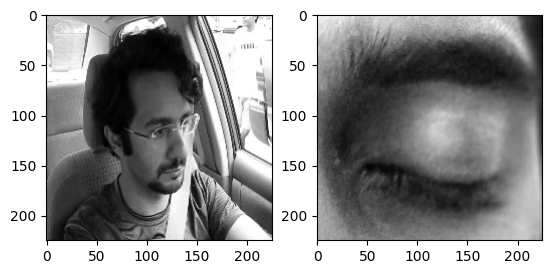

In [16]:
plt.figure()

f, axarr = plt.subplots(1,2) 

axarr[0].imshow(mouth_test[0], cmap = 'gray')
axarr[1].imshow(eyes_test[0], cmap = 'gray')

In [18]:
def drowsiness_predict(eyes, mouth, threshold, model):
    result = model.predict([np.array([eyes]), np.array([mouth])])

    if (result[0] > threshold and result[1] > threshold) or (result[0] > threshold and result[1] < threshold):
        print('Terdeteksi Kantuk')
    elif result[0] < threshold and result[1] < threshold:
        print('Kondisi Bangun')
    else:
        print('Terdeteksi Kelelahan, Istirahat!')
        

In [19]:
drowsiness_predict(eyes_test[0], mouth_test[0], 0.1, model)

1/1 [==============================] - 0s 182ms/step
Terdeteksi Kantuk
